# Predicció de resultats de fútbol (1a divisió espanyola) amb un analisis segons si juguen com a local o visitant i històric

### OBJECTIUS

Ara que ja he fet l'analisi prèvi tinc clar quins seran els meus objectius en que farem vàries actuacions per veure quin és el millor model i diferentes comparacions.

> **MACHINE LEARNING**
   + Models supervisats de regressió i classificació 
   + Utilitzarem vàris models per veure quin treballa millor dels que hem vist durant el curs
   + Utilitzarem els hiperparametres i avaluarem els resultats
   + Podem comprovar alguns resultats ja que ja coneixem el resultats d'algunes jornades. 
   + Pels models de regressió haurem de dividir el dataset ja que sino tindriem dos targets (Gols Local i Gols visitant)
   + Pels models de classifcació en el nostre target serà la columna (1-X-2)
   + Haurem de fer varis preprocessats aixi com eliminar columnes.

> **COMPARACIONS A REALITZAR**

   + PCA o sense PCA
   + Voldré comparar si val la pena tenir en compte tots els resultats o val més la pena els partits que han jugat directament, encara que això reduïrà molt el dataset.
   + Sense el Barça i el Madrid ja que son els més fàcils de predir

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Import preprocessing libraries
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from scipy import stats
from scipy.stats import shapiro
from sklearn.pipeline import Pipeline, make_pipeline

# Import models selection and algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, KFold, cross_validate, cross_val_score, cross_val_predict


In [2]:
# Import two dataset create
df_pfinal = pd.read_csv("resultados_pfinal.csv", sep = ",", encoding="utf-8-sig")

# Show principal dataset
df_pfinal

,Temporada,Jornada,Fecha,Local,Visitante,GolesLocal,GolesVisitante,Quiniela,LP,VP,...,V10r,LV_10cL,LE_10cL,LF_10cL,VV_10cV,VE_10cV,VD_10cV,Periode,L_Handicap,V_Handicap
0,1928-29,1,1929-02-10,Arenas de Guecho,Atlético de Madrid,2,3,2,0,3,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
1,1928-29,1,1929-02-10,Espanyol,Real Unión,3,2,1,3,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
2,1928-29,1,1929-02-10,Real Sociedad,Athletic Club,1,1,X,1,1,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
3,1928-29,1,1929-02-10,Real Madrid,Europa,5,0,1,3,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
4,1928-29,1,1929-02-12,Racing de Santander,Barcelona,0,2,2,0,3,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26520,2022-23,33,2023-05-03,Valencia,Villarreal,1,1,X,1,1,...,1.3,4.0,2.0,4.0,4.0,1.0,5.0,4,3,3
26521,2022-23,33,2023-05-03,Getafe,Celta de Vigo,1,0,1,3,0,...,1.3,4.0,3.0,3.0,3.0,4.0,3.0,4,3,3
26522,2022-23,33,2023-05-02,Barcelona,Osasuna,1,0,1,3,0,...,1.1,8.0,2.0,0.0,2.0,5.0,3.0,4,1,3
26523,2022-23,33,2023-05-02,Almería,Elche,2,1,1,3,0,...,0.4,4.0,2.0,4.0,1.0,1.0,8.0,4,4,4


In [3]:
# Find which index row i have to cut to complete my dataset
df_pfinal.loc[(df_pfinal["Temporada"] == "1980-81")]

,Temporada,Jornada,Fecha,Local,Visitante,GolesLocal,GolesVisitante,Quiniela,LP,VP,...,V10r,LV_10cL,LE_10cL,LF_10cL,VV_10cV,VE_10cV,VD_10cV,Periode,L_Handicap,V_Handicap
10499,1980-81,1,1980-09-06,Espanyol,Hércules,2,1,1,3,0,...,0.5,5.0,3.0,2.0,1.0,2.0,7.0,1,3,3
10500,1980-81,1,1980-09-06,Sporting de Gijón,Betis,2,0,1,3,0,...,0.8,6.0,3.0,1.0,1.0,5.0,4.0,1,4,3
10501,1980-81,1,1980-09-06,Sevilla,Salamanca,1,0,1,3,0,...,0.8,8.0,1.0,1.0,2.0,2.0,6.0,1,3,4
10502,1980-81,1,1980-09-06,Valencia,Real Sociedad,3,2,1,3,0,...,1.3,6.0,4.0,0.0,2.0,7.0,1.0,1,2,2
10503,1980-81,1,1980-09-07,Almería,Real Madrid,1,2,2,0,3,...,1.6,5.0,5.0,0.0,4.0,4.0,2.0,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10800,1980-81,34,1981-04-26,Sporting de Gijón,Real Sociedad,2,2,X,1,1,...,1.5,8.0,1.0,1.0,4.0,3.0,3.0,3,4,2
10801,1980-81,34,1981-04-26,Murcia,Hércules,2,2,X,1,1,...,0.9,4.0,3.0,3.0,2.0,3.0,5.0,3,3,3
10802,1980-81,34,1981-04-26,Sevilla,Barcelona,1,1,X,1,1,...,0.9,6.0,4.0,0.0,2.0,3.0,5.0,3,3,1
10803,1980-81,34,1981-04-26,Valencia,Las Palmas,3,1,1,3,0,...,1.3,6.0,4.0,0.0,4.0,1.0,5.0,3,2,3


In [4]:
# Drop rows we are not interested
df_pfinal.drop(df_pfinal.index[0:10499], inplace=True)

In [5]:
# Reset index of dataframe
df_pfinal = df_pfinal.reset_index(drop=True)
df_pfinal.head(10)

,Temporada,Jornada,Fecha,Local,Visitante,GolesLocal,GolesVisitante,Quiniela,LP,VP,...,V10r,LV_10cL,LE_10cL,LF_10cL,VV_10cV,VE_10cV,VD_10cV,Periode,L_Handicap,V_Handicap
0,1980-81,1,1980-09-06,Espanyol,Hércules,2,1,1,3,0,...,0.5,5.0,3.0,2.0,1.0,2.0,7.0,1,3,3
1,1980-81,1,1980-09-06,Sporting de Gijón,Betis,2,0,1,3,0,...,0.8,6.0,3.0,1.0,1.0,5.0,4.0,1,4,3
2,1980-81,1,1980-09-06,Sevilla,Salamanca,1,0,1,3,0,...,0.8,8.0,1.0,1.0,2.0,2.0,6.0,1,3,4
3,1980-81,1,1980-09-06,Valencia,Real Sociedad,3,2,1,3,0,...,1.3,6.0,4.0,0.0,2.0,7.0,1.0,1,2,2
4,1980-81,1,1980-09-07,Almería,Real Madrid,1,2,2,0,3,...,1.6,5.0,5.0,0.0,4.0,4.0,2.0,1,4,2
5,1980-81,1,1980-09-07,Athletic Club,Zaragoza,0,1,2,0,3,...,1.0,9.0,1.0,0.0,3.0,1.0,6.0,1,2,3
6,1980-81,1,1980-09-07,Atlético de Madrid,Valladolid,5,2,1,3,0,...,0.4,6.0,2.0,2.0,1.0,1.0,8.0,1,2,3
7,1980-81,1,1980-09-07,Murcia,Barcelona,1,2,2,0,3,...,0.9,4.0,3.0,3.0,1.0,6.0,3.0,1,3,1
8,1980-81,1,1980-09-07,Osasuna,Las Palmas,1,0,1,3,0,...,0.7,7.0,1.0,2.0,2.0,1.0,7.0,1,4,3
9,1980-81,2,1980-09-13,Barcelona,Espanyol,3,1,1,3,0,...,0.6,7.0,2.0,1.0,1.0,3.0,6.0,1,1,3


In [6]:
# Shape of df
df_pfinal.shape

(16026, 25)

In [7]:
# Basic info of df
df_pfinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16026 entries, 0 to 16025
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temporada       16026 non-null  object 
 1   Jornada         16026 non-null  int64  
 2   Fecha           16026 non-null  object 
 3   Local           16026 non-null  object 
 4   Visitante       16026 non-null  object 
 5   GolesLocal      16026 non-null  int64  
 6   GolesVisitante  16026 non-null  int64  
 7   Quiniela        16026 non-null  object 
 8   LP              16026 non-null  int64  
 9   VP              16026 non-null  int64  
 10  L10gf_cL        15896 non-null  float64
 11  V10gf_cV        15896 non-null  float64
 12  L10gc_cL        15896 non-null  float64
 13  V10gc_cV        15896 non-null  float64
 14  L10r            15896 non-null  float64
 15  V10r            15896 non-null  float64
 16  LV_10cL         16026 non-null  float64
 17  LE_10cL         16026 non-null 

## Que fer abans de començar a explorar el dataset

> 0. Observacions inicials
> 1. Descripció de les variables i comprovació del tipus de dada que tenim
> 2. Canvis prinicpals en el dataset -> Noms/Ordre columnes
> 3. Netjar el dataset -> NaNs, Nulls, duplicats

#### 0. Observacions inicials

0. El dataset original hem vist que tenia un total de 26.525 observacions. Tot i això crec que moltes d'aquestes observacions son de temporades massa anteriors i que no te sentit analitzar ni utilitzar, per això he decidit fer el tall a partir de la temporada 1980-1981. 

1. La forma del df final (la part que ens interessa) és d'un total de 16.026 observacions i 25 columnes les quals les describirem més endavant. 

2. Podem veure que en aquest dataset tracta dels resultats i estadístiques dels partits de futbol de la primera divisió espanyola desde la temporada 1980-1981.

3. Amb aquesta reducció veiem que han desaparegut alguns NANS que es mostraven en el dataset original per falta de dades anteriors segurament al crear les columnes jo mateix. 

4. Amb l'exploració de la funció _.info_ veiem que hi ha més columnes amb valors Nulls. Haurem d'estudiarlos tot i que ja ens donem compte que no hi ha molts. Menys de 300. La meva teoria (al haver creat jo les columnes) és que son equips que no han disputat suficients partits a primera divisió i per tant els hi falta dades. 

#### 1. Descripció de les variables i comprovació del tipus de dada que tenim

0. **Temporada**:     Descriu quina temporada estem (_obj_) 
1. **Jornada**:       Número de la jornada en que es va jugar el partit. És un index que es va repetint. (_int o obj_)  
2. **Fecha**:         Mostra el dia en que es va jugar el partit. És una data (_datetime or obj_)
3. **Local**:         Mostra el nom de l'equip local d'aquell partit (_obj_) 
4. **Visitante**:     Mostra el nom de l'equip visitant d'aquell partit (_obj_) 
5. **GolesLocal**:    Mostra el número de gols de l'equip local en aquell partit (_int64_)  
6. **GolesVisitante**:Mostra el número de gols de l'equip visitant en aquell partit (_int64_) 
7. **Quiniela**:      Mostra el resultat d'aquell partit (1= Ha guanyat l'equip Local, X= Han empatat, 2= Ha guanyat l'equip visitant) (_obj_) 
8. **LP**:            Punts de l'equip local aconseguits en aquell partit (3=Victoria, 1=Empat, 0=Derrota). (_int64_)  
9. **VP**:            Punts de l'equip visitant aconseguits en aquell partit (3=Victoria, 1=Empat, 0=Derrota). (_int64_)  
10. **L10gf_cL**:     Mitjà de gols a favor de l'equip local en els últims 10 partits com a local abans d'aquest partit (_float64_)
11. **V10gf_cV**:     Mitjà de gols a favor de l'equip visitant en els últims 10 partits com a visitant abans d'aquest partit (_float64_)
12. **L10gc_cL**:     Mitjà de gols en contra de l'equip local en els últims 10 partits com a local abans d'aquest partit (_float64_)
13. **V10gc_cV**:     Mitjà de gols en contra de l'equip visitant en els últims 10 partits com a visitant abans d'aquest partit (_float64_)
14. **L10r**:         Mitjà de punts de l'equip local en els últims 10 partits com a local abans d'aquest partit (_float64_)
15. **V10r**:         Mitjà de punts de l'equip visitant en els últims 10 partits com a visitant abans d'aquest partit (_float64_)
16. **LV_10cL**:      Número de victòries de l'equip local ens els últims 10 partits com a local abans d'aquest partit (_int_)
17. **LE_10cL**:      Número d'empats de l'equip local ens els últims 10 partits com a local abans d'aquest partit (_int_)
18. **LF_10cL**:      Número de derrotes de l'equip local ens els últims 10 partits com a local abans d'aquest partit (_int_)
19. **VV_10cV**:      Número de victòries de l'equip visitant ens els últims 10 partits com a visitant abans d'aquest partit (_int_)
20. **VE_10cV**:      Número d'empats de l'equip visitant ens els últims 10 partits com a visitant abans d'aquest partit (_int_)
21. **VD_10cV**:      Número de derrotes de l'equip visitant ens els últims 10 partits com a visitant abans d'aquest partit (_int_)
22. **Periode**:      Divisió en 4 períodes segons el moment de la temporada (1=01/08 a 31/10, 2=01/11 al 31/01, 3=01/02 al 31/04 i 4='1/05 al 31/07 (_int_ o _obj_)   
23. **L_Handicap**:   Valor que se li dona a l'equip local segons la posició mitjana de les darreres 10 temporades (1= Pos <=3, 2= 3< Pos<=7, 3= 7<Pos<14, 4= la resta) (_int_)
24. **V_Handicap**:   Valor que se li dona a l'equip visitant segons la posició mitjana de les darreres 10 temporades (1= Pos <=3, 2= 3< Pos<=7, 3= 7<Pos<14, 4= la resta) (_int_)

In [8]:
# Change dtypes of columns that are int and we have it as float.
df_pfinal[["LV_10cL", "LE_10cL", "LF_10cL", "VV_10cV", "VE_10cV", "VD_10cV"]] = df_pfinal[["LV_10cL", "LE_10cL", "LF_10cL", "VV_10cV", "VE_10cV", "VD_10cV"]].astype(int)

# Check it
df_pfinal.dtypes

Temporada          object
Jornada             int64
Fecha              object
Local              object
Visitante          object
GolesLocal          int64
GolesVisitante      int64
Quiniela           object
LP                  int64
VP                  int64
L10gf_cL          float64
V10gf_cV          float64
L10gc_cL          float64
V10gc_cV          float64
L10r              float64
V10r              float64
LV_10cL             int32
LE_10cL             int32
LF_10cL             int32
VV_10cV             int32
VE_10cV             int32
VD_10cV             int32
Periode             int64
L_Handicap          int64
V_Handicap          int64
dtype: object

In [9]:
# Know how many unique values are in each column
df_pfinal.nunique()

Temporada           43
Jornada             44
Fecha             3941
Local               51
Visitante           51
GolesLocal          11
GolesVisitante       9
Quiniela             3
LP                   3
VP                   3
L10gf_cL            45
V10gf_cV            38
L10gc_cL            31
V10gc_cV            44
L10r                28
V10r                30
LV_10cL             11
LE_10cL             10
LF_10cL             10
VV_10cV             11
VE_10cV              9
VD_10cV             11
Periode              4
L_Handicap           4
V_Handicap           4
dtype: int64

**Podem extreure la següent informació**:
1. Hi ha 43 temporades.
2. El número màxim de jornades que hi hagut en una temporada és 44.
3. Hi han participat 51 equips diferents
4. El número màxim de gols com a local que ha fet un equip han estat 10 (11-1 perquè pot ser valor 0) i com a visitant 8. 
5. Els locals tant en els empats i derrotes mai s'han arribat a les 10 consecutives (suposo que és el més elevat). I els visitants passa amb els empats però en dos ocasions, suposo que ni 9 ni 10 en els darrers 10 partits.
6. També hem vist que una de les opcions de target ("Quiniela") es una variable objecte perquè un dels valors és una X i per tant no pot ser númerica. Crec que una bona solució és convertir la X en 0 i passar-la a númerica.  

In [10]:
# Replace values of Quiniela column to be numeric and not a string
df_pfinal["Quiniela"] = df_pfinal["Quiniela"].replace({"1" : 1, "X" : 3, "2" : 2})
df_pfinal.dtypes

Temporada          object
Jornada             int64
Fecha              object
Local              object
Visitante          object
GolesLocal          int64
GolesVisitante      int64
Quiniela            int64
LP                  int64
VP                  int64
L10gf_cL          float64
V10gf_cV          float64
L10gc_cL          float64
V10gc_cV          float64
L10r              float64
V10r              float64
LV_10cL             int32
LE_10cL             int32
LF_10cL             int32
VV_10cV             int32
VE_10cV             int32
VD_10cV             int32
Periode             int64
L_Handicap          int64
V_Handicap          int64
dtype: object

#### 2. Canvis prinicpals en el dataset -> Noms/Ordre columnes

In [11]:
# Change the column names to make it shorter
df_pfinal.columns = ["Temp", "Jor", "Data", "Loc", "Vis", "LG", "VG", "1-X-2", "LP", "VP", "L10gf_cL", "V10gf_cV", "L10gc_cL", "V10gc_cV", "L10r", "V10r", "LV_10cL", "LE_10cL", "LD_10cL", "VV_10cV", "VE_10cV", "VD_10cV", "Per", "L_Han", "V_Han"]

# Check it
df_pfinal.head(5)

,Temp,Jor,Data,Loc,Vis,LG,VG,1-X-2,LP,VP,...,V10r,LV_10cL,LE_10cL,LD_10cL,VV_10cV,VE_10cV,VD_10cV,Per,L_Han,V_Han
0,1980-81,1,1980-09-06,Espanyol,Hércules,2,1,1,3,0,...,0.5,5,3,2,1,2,7,1,3,3
1,1980-81,1,1980-09-06,Sporting de Gijón,Betis,2,0,1,3,0,...,0.8,6,3,1,1,5,4,1,4,3
2,1980-81,1,1980-09-06,Sevilla,Salamanca,1,0,1,3,0,...,0.8,8,1,1,2,2,6,1,3,4
3,1980-81,1,1980-09-06,Valencia,Real Sociedad,3,2,1,3,0,...,1.3,6,4,0,2,7,1,1,2,2
4,1980-81,1,1980-09-07,Almería,Real Madrid,1,2,2,0,3,...,1.6,5,5,0,4,4,2,1,4,2


In [12]:
# Reorder the columns to more logic order
df_pfinal = df_pfinal[["Temp", "Jor", "Data", "Per", "Loc", "Vis", "LG", "VG", "1-X-2", "LP", "VP", "L_Han","L10r", "L10gf_cL", "L10gc_cL",  "LV_10cL", "LE_10cL", "LD_10cL", "V_Han", "V10r",  "V10gf_cV",  "V10gc_cV", "VV_10cV", "VE_10cV", "VD_10cV"]]

# Check it
df_pfinal.head(5)

,Temp,Jor,Data,Per,Loc,Vis,LG,VG,1-X-2,LP,...,LV_10cL,LE_10cL,LD_10cL,V_Han,V10r,V10gf_cV,V10gc_cV,VV_10cV,VE_10cV,VD_10cV
0,1980-81,1,1980-09-06,1,Espanyol,Hércules,2,1,1,3,...,5,3,2,3,0.5,0.8,1.5,1,2,7
1,1980-81,1,1980-09-06,1,Sporting de Gijón,Betis,2,0,1,3,...,6,3,1,3,0.8,0.9,1.4,1,5,4
2,1980-81,1,1980-09-06,1,Sevilla,Salamanca,1,0,1,3,...,8,1,1,4,0.8,0.3,1.1,2,2,6
3,1980-81,1,1980-09-06,1,Valencia,Real Sociedad,3,2,1,3,...,6,4,0,2,1.3,1.1,0.8,2,7,1
4,1980-81,1,1980-09-07,1,Almería,Real Madrid,1,2,2,0,...,5,5,0,2,1.6,1.0,1.0,4,4,2


#### 3. Netjar el dataset -> NaNs, Nulls, duplicats

In [13]:
# Show nulls, NaNs and duplicates
print("\033[1mNans:\n\033[0m", df_pfinal.isna().sum(), "\033[1m\n\nNulls:\n\033[0m", df_pfinal.isnull().sum(), "\033[1m\n\nDuplicats:\n\033[0m", df_pfinal.duplicated().sum())

Nans:
 Temp          0
Jor           0
Data          0
Per           0
Loc           0
Vis           0
LG            0
VG            0
1-X-2         0
LP            0
VP            0
L_Han         0
L10r        130
L10gf_cL    130
L10gc_cL    130
LV_10cL       0
LE_10cL       0
LD_10cL       0
V_Han         0
V10r        130
V10gf_cV    130
V10gc_cV    130
VV_10cV       0
VE_10cV       0
VD_10cV       0
dtype: int64 

Nulls:
 Temp          0
Jor           0
Data          0
Per           0
Loc           0
Vis           0
LG            0
VG            0
1-X-2         0
LP            0
VP            0
L_Han         0
L10r        130
L10gf_cL    130
L10gc_cL    130
LV_10cL       0
LE_10cL       0
LD_10cL       0
V_Han         0
V10r        130
V10gf_cV    130
V10gc_cV    130
VV_10cV       0
VE_10cV       0
VD_10cV       0
dtype: int64 

Duplicats:
 0


_Observem que es repeteixen els NaNs i Nulls en les mateixes columnes. Segurament es repetiren en files alternes ja que tal i com sospitem, es deu a faltes de dades dels equips amb poca participació a la primera divisió espanyola. Per tant segons si juguen com a locals o visitants es van alternant les Nans. 130 files de 16.026 son un 0,81% aprox de les dades. Podriem eliminarles pero vull mirar si podem arreglar-ho per no perdre dades. Per altra banda, no tenim files duplicades_ 

In [14]:
# check Nans rows and create a variable to work with it
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_pfinal[df_pfinal.isna().any(axis=1)]

,Temp,Jor,Data,Per,Loc,Vis,LG,VG,1-X-2,LP,VP,L_Han,L10r,L10gf_cL,L10gc_cL,LV_10cL,LE_10cL,LD_10cL,V_Han,V10r,V10gf_cV,V10gc_cV,VV_10cV,VE_10cV,VD_10cV
2235,1987-88,1,1987-08-29,1,Valencia,Logroñés,2,0,1,3,0,3,0.9,0.9,1.4,2,3,5,4,NaN,NaN,NaN,0,0,0
2245,1987-88,2,1987-09-06,1,Logroñés,Athletic Club,1,1,3,1,1,4,NaN,NaN,NaN,0,0,0,2,0.6,0.5,1.3,1,3,6
2258,1987-88,3,1987-09-13,1,Atlético de Madrid,Logroñés,3,0,1,3,0,2,2.1,1.8,1.2,7,0,3,4,NaN,NaN,NaN,0,0,1
2262,1987-88,4,1987-09-19,1,Logroñés,Sabadell,1,1,3,1,1,4,NaN,NaN,NaN,0,1,0,3,0.7,0.5,1.3,1,4,5
2277,1987-88,5,1987-09-27,1,Mallorca,Logroñés,4,0,1,3,0,4,1.5,1.1,1.4,4,3,3,4,NaN,NaN,NaN,0,0,2
2286,1987-88,6,1987-10-04,1,Logroñés,Cádiz,1,2,2,0,3,4,NaN,NaN,NaN,0,2,0,4,0.6,1.0,1.9,2,0,8
2297,1987-88,7,1987-10-18,1,Logroñés,Celta de Vigo,0,0,3,1,1,4,NaN,NaN,NaN,0,2,1,3,0.5,0.4,1.9,1,2,7
2304,1987-88,8,1987-10-25,1,Betis,Logroñés,1,1,3,1,1,3,2.5,3.1,0.8,8,1,1,4,NaN,NaN,NaN,0,0,3
2317,1987-88,9,1987-11-01,2,Logroñés,Barcelona,0,1,2,0,3,4,NaN,NaN,NaN,0,3,1,1,1.4,0.9,0.7,4,2,4
2327,1987-88,10,1987-11-08,2,Murcia,Logroñés,2,3,2,0,3,4,2.1,2.1,0.9,7,0,3,4,NaN,NaN,NaN,0,1,3


In [15]:
# Show the teams that are generating NaNs
print("Hi ha un total de", df_pfinal.loc[df_pfinal["L10r"].isna()]["Loc"].nunique(), 
      "equips locals que generan NaNs i aquests són: \n", df_pfinal.loc[df_pfinal["L10r"].isna()]["Loc"].unique())
print("\n\n Hi ha un total de", df_pfinal.loc[df_pfinal["V10r"].isna()]["Vis"].nunique(), 
      "equips visitants que generan NaNs i aquests són:  \n", df_pfinal.loc[df_pfinal["V10r"].isna()]["Vis"].unique())

Hi ha un total de 13 equips locals que generan NaNs i aquests són: 
 ['Logroñés' 'Albacete' 'Compostela' 'Mérida' 'Extremadura' 'Villarreal'
 'Numancia' 'Getafe' 'Xerez' 'Eibar' 'Leganés' 'Girona' 'Huesca']


 Hi ha un total de 13 equips visitants que generan NaNs i aquests són:  
 ['Logroñés' 'Albacete' 'Compostela' 'Mérida' 'Extremadura' 'Villarreal'
 'Numancia' 'Getafe' 'Xerez' 'Eibar' 'Leganés' 'Girona' 'Huesca']


Veiem que "només" son 13 equips que generan NaNs, curiosament 130 x 10 = 130 (el mateix número de NaNs que tenim) i 10 és el valor utilitzat alhora de crear les columnes de refèrencia.

Per tant la conclusió d'aquests NaNs és que es tracta dels primers 10 partits d'aquests equips que participen a la primera divisió. Possibles actuacions:  
    a) Que enlloc de que la mitja sigui de 10 partits, fins que no hi arribin calcular la mitja dels partits anteriors i la
       primera marcar-la com a 0.   
    b) Convertir els NaNs en 0.   
    c) **Eliminar les files.**
    
L'opció B la descarto perquè crec que afectaria al model alhora d'entrenar-lo si posem aquestes estadístiques a 0. Ja que partirien en desvantatge amb altres equips acabats d'ascendir però que si havien participat abans de la temporada que hem marcat de tall 1980-1981. 

L'opció A, tot i que em sembla millor que l'opció B també em penso que afectaria a l'entrenament d'aquests equips en el model.

Per tant, tenint en compte que segurament son només 10 resultats per equip i que el total de Nulls equivalen a un 0,81% de les dades les eliminem.

In [16]:
# Drop NaNs
df_pfinal = df_pfinal.dropna()

# Check if there still NaNs or Nulls
print("\033[1mNans:\n\033[0m", df_pfinal.isna().sum(), "\033[1m\n\nNulls:\n\033[0m", df_pfinal.isnull().sum())

Nans:
 Temp        0
Jor         0
Data        0
Per         0
Loc         0
Vis         0
LG          0
VG          0
1-X-2       0
LP          0
VP          0
L_Han       0
L10r        0
L10gf_cL    0
L10gc_cL    0
LV_10cL     0
LE_10cL     0
LD_10cL     0
V_Han       0
V10r        0
V10gf_cV    0
V10gc_cV    0
VV_10cV     0
VE_10cV     0
VD_10cV     0
dtype: int64 

Nulls:
 Temp        0
Jor         0
Data        0
Per         0
Loc         0
Vis         0
LG          0
VG          0
1-X-2       0
LP          0
VP          0
L_Han       0
L10r        0
L10gf_cL    0
L10gc_cL    0
LV_10cL     0
LE_10cL     0
LD_10cL     0
V_Han       0
V10r        0
V10gf_cV    0
V10gc_cV    0
VV_10cV     0
VE_10cV     0
VD_10cV     0
dtype: int64


_Ja no tenim ni NaNs ni Nulls. En aquest altre notebook del repositori tinc l'exploració del dataset així que pasaré directament al preprocessat i els models de classificació. Si vols veure l'altre notebook, clica [aqui](https://github.com/borch008/M11_Projecte-final/blob/main/Projecte%20final_Part%201%20(Regressio).ipynb)_

## PREPROCESSAT
   0. Eliminació de columnes així com divisió d'aquestes segons la seva categoria. 
   1. Distribució de les variables i veure tipus d'outliers
   2. Crear un pipeline de preprocessat de les columnes.

In [17]:
# Take a look columns name
df_pfinal.columns

Index(['Temp', 'Jor', 'Data', 'Per', 'Loc', 'Vis', 'LG', 'VG', '1-X-2', 'LP',
       'VP', 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL',
       'LD_10cL', 'V_Han', 'V10r', 'V10gf_cV', 'V10gc_cV', 'VV_10cV',
       'VE_10cV', 'VD_10cV'],
      dtype='object')

**CLASSIFICACIÓ DE COLUMNES**
   + Columnes que no utilitzarem -> Temp, Jor, Data, LP i VP (aquestes dues son directament consecuencia del target i no les podem obtenir sense saber el resultat, per tant no les podem utilitzar
   + Columnes TARGET -> LG i VG (per models de regressió) i "1-X-2" (models de classificació).
   + Dummies -> "Loc" i "Vis" -> Surtiren molts dummies :(.
   + Features númerics (la resta) -> 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 
     'V_Han', 'V10r', 'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV'

Creerem un nou objecte amb un df per veure la distribució de les variables númeriques i target. Els dummies ja sabem que no tindren distribució gaussiana i els targets s'estudien per separat ja que és el que voldrem predir. 

In [18]:
# Define type of preproceed
onehot = OneHotEncoder(drop="first", handle_unknown="ignore")
minmax = MinMaxScaler()
robusts = RobustScaler()

In [19]:
# Define the preproceed for each type of variable
preprocessor = ColumnTransformer(
                [("Categoric", onehot, ["Loc", "Vis"]), 
                 ("MinMax", minmax, ["Per"]), 
                 ("Robust", robusts, ['L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 'V_Han', 'V10r',
                                      'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV'])], 
    remainder = "drop")

In [20]:
# Features
X = df_pfinal[['Per', 'Loc', 'Vis', 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 'V_Han', 'V10r', 'V10gf_cV', 
        'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV']]

# Diferent targets
yl = df_pfinal["LG"]
yv = df_pfinal["VG"]
yc = df_pfinal["1-X-2"]

print("Forma Features:", X.shape)
print("Forma Target Gols Locals:", yl.shape)
print("Forma Target Gols Visitants:", yv.shape)
print("Forma Target resultat:", yc.shape)

Forma Features: (15766, 17)
Forma Target Gols Locals: (15766,)
Forma Target Gols Visitants: (15766,)
Forma Target resultat: (15766,)


## CREACIÓ MODELS

> 1. Regressió
> 2. Classificació

#### 2. Classificació

In [21]:
# Define models and pipelines
knc_pipeline = Pipeline([('prep',preprocessor), ('knc', KNeighborsClassifier())])
dtc_pipeline = Pipeline([('prep',preprocessor), ('dtc', DecisionTreeClassifier(random_state = 5))])
svc_pipeline = Pipeline([('prep',preprocessor), ('svc', SVC(random_state = 5))])
rfc_pipeline = Pipeline([('prep',preprocessor), ('rfc', RandomForestClassifier(random_state = 5))])
lr_pipeline = Pipeline([('prep',preprocessor), ('lr', LogisticRegression())])

In [22]:
# Split data into train i test
X_train, X_test, yc_train, yc_test = train_test_split(X, yc, test_size=0.3, random_state=5)

In [23]:
# Call pipeline to preprocess data and call model 
lr_pipeline

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('Categoric',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Loc', 'Vis']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['Per']),
                                                 ('Robust', RobustScaler(),
                                                  ['L_Han', 'L10r', 'L10gf_cL',
                                                   'L10gc_cL', 'LV_10cL',
                                                   'LE_10cL', 'LD_10cL',
                                                   'V_Han', 'V10r', 'V10gf_cV',
                                                   'V10gc_cV', 'VV_10cV',
                                                   'VE_10cV', 'VD_10cV'])])),
      

In [24]:
# Fit one model to take a first look
lr_pipeline.fit(X_train, yc_train)
print('f1 score: {0:.5f}'.format(lr_pipeline.score(X_test, yc_test)))

f1 score: 0.52431


In [25]:
# Take a look of first prediction for test data
lr_pipeline.predict(X_test)

array([2, 1, 1, ..., 1, 1, 1], dtype=int64)

In [26]:
# Create a df to itirate
classificacio = [("knc", knc_pipeline), ("dtc", dtc_pipeline), ("svc", svc_pipeline), ("rfc", rfc_pipeline), ("lr", lr_pipeline)]

for name, model in classificacio:
    cv = cross_val_score(model, X, yc, cv=5, scoring='f1_micro')
    
    print("CV for", f"\033[1m{name}\033[0m \n", cv, "\n", "F1 mean: {:.3f}, std: {:.3f} \n".format(cv.mean(), cv.std()))

CV for knc 
 [0.46068484 0.44560736 0.43133524 0.46336822 0.46590549] 
 F1 mean: 0.453, std: 0.013 

CV for dtc 
 [0.41566265 0.38820171 0.39517919 0.39010466 0.42848081] 
 F1 mean: 0.404, std: 0.016 

CV for svc 
 [0.51775523 0.50047574 0.49888995 0.52521408 0.53219156] 
 F1 mean: 0.515, std: 0.013 

CV for rfc 
 [0.50919467 0.47288297 0.47700603 0.50015858 0.50713606] 
 F1 mean: 0.493, std: 0.015 

CV for lr 
 [0.52219404 0.47764034 0.48778941 0.52140818 0.51569933] 
 F1 mean: 0.505, std: 0.019 



Text(0, 0.5, 'F1 Score')

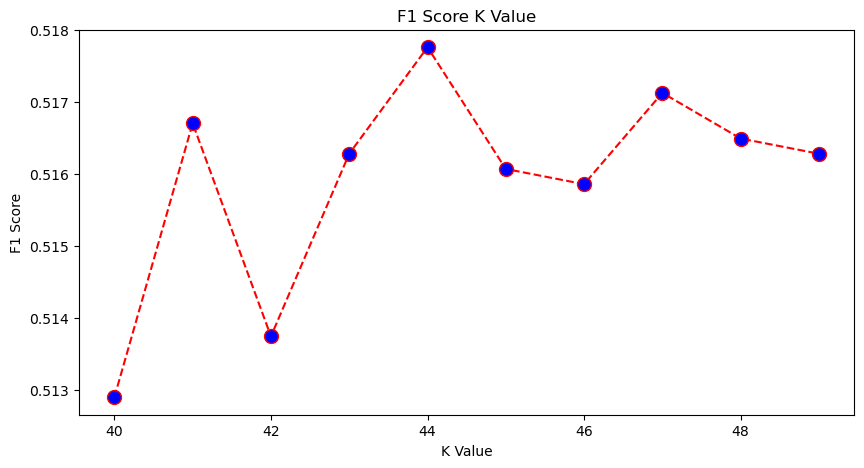

In [27]:
# Finding best number for k 
# Creat the variable f1s and calculate f1s for k values between 1 and 40
f1s = []

for i in range(40, 50):
    knc_pipeline = Pipeline([('prep',preprocessor), ('knc', KNeighborsClassifier(n_neighbors=i))])
    knc_pipeline.fit(X_train, yc_train)
    pred_i = knc_pipeline.predict(X_test)
    ## using average='weighted' to calculate a weighted average for the 4 classes 
    f1s.append(f1_score(yc_test, pred_i, average='micro'))

# Plot f1s values against K-values, the only differences from regression is to choose the k value that max f1s
plt.figure(figsize=(10, 5))
plt.plot(range(40, 50), f1s, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

In [28]:
# Define hyperparameters
params_knc = {"knc__algorithm": ["auto", "ball_tree", "kd_tree", "brute"], "knc__leaf_size": [10, 30, 50], 
              "knc__metric": ["minkowski", "manhattan", "euclidean", "chebyshev"], "knc__n_neighbors" : [44]}

params_dtc = {"dtc__ccp_alpha" : [0.1, 0.5, 1, 2, 5, 10], "dtc__criterion" : ["gini", "entropy"], 
              'dtc__max_features': [None, "auto", "sqrt", "log2"], "dtc__class_weight" : [None, "balanced"]}

params_svc = {"svc__C": [0.1, 1, 10, 5], "svc__kernel": ["linear", "poly", "rbf"], "svc__gamma": ["auto", "scale"]}

params_rfc = {"rfc__bootstrap" : [True, False], "rfc__criterion" : ["gini", "entropy"], 
              "rfc__class_weight" : [None, "balanced"]}

params_lr =  {"lr__C" : [0.05, 0.1, 0.15, 0.2, 0.25], "lr__penalty" : ["l1", "l2", "elasticnet"], 
              "lr__solver" : ["liblinear", "sag", "lbfgs", "newton-cg", "saga"]}

In [29]:
# Recall models as i used KNNeighbors to find out k value
# Define models and pipelines
knc_pipeline = Pipeline([('prep',preprocessor), ('knc', KNeighborsClassifier())])
dtc_pipeline = Pipeline([('prep',preprocessor), ('dtc', DecisionTreeClassifier(random_state = 5))])
svc_pipeline = Pipeline([('prep',preprocessor), ('svc', SVC(random_state = 5))])
rfc_pipeline = Pipeline([('prep',preprocessor), ('rfc', RandomForestClassifier(random_state = 5))])
lr_pipeline = Pipeline([('prep',preprocessor), ('lr', LogisticRegression())])

# Declare objects
classificacio = [("knc", knc_pipeline), ("dtc", dtc_pipeline), ("svc", svc_pipeline), ("rfc", rfc_pipeline), ("lr", lr_pipeline)]
hyper_params = [("knc", params_knc), ("dtc", params_dtc), ("svc", params_svc), ("rfc", params_rfc), ("lr", params_lr)]

for name, model in classificacio:
    params = next(hp for hp in hyper_params if hp[0] == name)[1]
    
    grids = GridSearchCV(model, params, cv=5, scoring=['f1_micro', 'accuracy'], refit='f1_micro', n_jobs=-1)
    grids.fit(X, yc)
    
    print(name)
    print(f"El millor resultat per f1 és {grids.best_score_:.3f}")
    print(f"Els millors hiperparametres per dtc son: {grids.best_params_}\n")

knc
El millor resultat per f1 és 0.503
Els millors hiperparametres per dtc son: {'knc__algorithm': 'auto', 'knc__leaf_size': 10, 'knc__metric': 'manhattan', 'knc__n_neighbors': 44}

dtc
El millor resultat per f1 és 0.492
Els millors hiperparametres per dtc son: {'dtc__ccp_alpha': 0.1, 'dtc__class_weight': None, 'dtc__criterion': 'gini', 'dtc__max_features': None}

svc
El millor resultat per f1 és 0.519
Els millors hiperparametres per dtc son: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

rfc
El millor resultat per f1 és 0.496
Els millors hiperparametres per dtc son: {'rfc__bootstrap': True, 'rfc__class_weight': 'balanced', 'rfc__criterion': 'entropy'}

lr
El millor resultat per f1 és 0.520
Els millors hiperparametres per dtc son: {'lr__C': 0.15, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}



_De moment el millor model es **LR** però tots tener resultats molt semblants_

#### PCA
En el model de regressió ja hem que el PCA no te gaire sentit fer-ho ja que no ens deixa aplicar-ho sense els dummies, i amb aquests no el podem calcular ja que ens dius que la dada esta molt dispersa o és escassa. 

In [30]:
# Recall models as i used KNNeighbors to find out k value
# Define models and pipelines
knc_pipeline = Pipeline([('prep',preprocessor), ('knc', KNeighborsClassifier(algorithm = 'auto', leaf_size = 10, metric = 'manhattan', n_neighbors = 44))])
dtc_pipeline = Pipeline([('prep',preprocessor), ('dtc', DecisionTreeClassifier(ccp_alpha = 0.1, class_weight = None, criterion = 'gini', max_features = None, random_state = 5))])
svc_pipeline = Pipeline([('prep',preprocessor), ('svc', SVC(C = 0.1, gamma = 'scale', kernel = 'rbf', random_state = 5))])
rfc_pipeline = Pipeline([('prep',preprocessor), ('rfc', RandomForestClassifier(bootstrap = True, class_weight = 'balanced', criterion = 'entropy', random_state = 5))])
lr_pipeline = Pipeline([('prep',preprocessor), ('lr', LogisticRegression(C = 0.15, penalty = 'l1', solver = 'liblinear'))])

Accuracy score: 0.53


Text(0.5, 3.722222222222216, 'Predicted label')

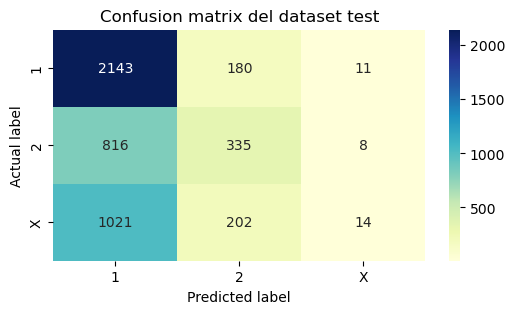

In [31]:
# Create a Confusion Matrix for best model LR
# Import libraries
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

# Fit
lr_pipeline.fit(X_train, yc_train)
print('Accuracy score: {0:.2f}'.format(lr_pipeline.score(X_test, yc_test)))

yc_pred = lr_pipeline.predict(X_test)
cnf_matrix = metrics.confusion_matrix(yc_test, yc_pred)

plt.figure(figsize=(6,3))
sns.heatmap(pd.DataFrame(cnf_matrix, columns= ["1", "2", "X"], index=["1", "2", "X"]), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix del dataset test', y=1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [32]:
# Test report 
print(classification_report(yc_test, yc_pred))

              precision    recall  f1-score   support

           1       0.54      0.92      0.68      2334
           2       0.47      0.29      0.36      1159
           3       0.42      0.01      0.02      1237

    accuracy                           0.53      4730
   macro avg       0.48      0.41      0.35      4730
weighted avg       0.49      0.53      0.43      4730



_he aconseguit una mitjana d'accuracy del 53% cosa que indica que el model no predeix molt bé però per sobre de l'aleatoriatat del principi (33% per classe). Per altra banda podem veure que les victòries erroneament classificades lleugerament les classifica més com a empat que com a derrota. Dins de l'equivocació millor que ho faci així. El mateix massa amb les derrotes, que lleugerement les classifica més com a empat que com a victòria. Per altra banda ràpidament observem que hi ha un problema de balanceig de les mostres. Mentre que de victòries locals tenim quasi 4000 mostres, de derrotes locals no arriba a 1000 i empats poc més de 30._

Anem a veure que passa si agafem tot el dataset

Accuracy score: 0.53


Text(0.5, 3.722222222222216, 'Predicted label')

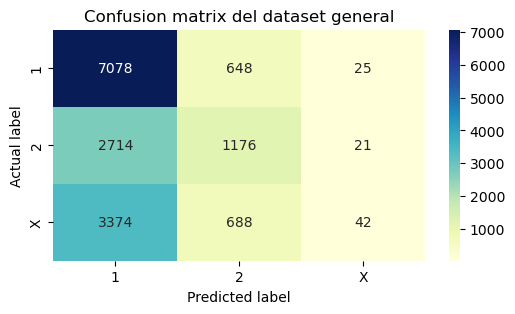

In [33]:
# Declare model again
lr_pipeline = Pipeline([('prep',preprocessor), ('lr', LogisticRegression(C = 0.15, penalty = 'l1', solver = 'liblinear'))])

# Fit
lr_pipeline.fit(X, yc)
print('Accuracy score: {0:.2f}'.format(lr_pipeline.score(X, yc)))

yc_pred = lr_pipeline.predict(X)
cnf_matrix = metrics.confusion_matrix(yc, yc_pred)

plt.figure(figsize=(6,3))
sns.heatmap(pd.DataFrame(cnf_matrix, columns= ["1", "2", "X"], index=["1", "2", "X"]), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix del dataset general', y=1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [34]:
print(classification_report(yc, yc_pred))

              precision    recall  f1-score   support

           1       0.54      0.91      0.68      7751
           2       0.47      0.30      0.37      3911
           3       0.48      0.01      0.02      4104

    accuracy                           0.53     15766
   macro avg       0.49      0.41      0.35     15766
weighted avg       0.50      0.53      0.43     15766



_veiem que passa exactament el mateix, sobretot pel que fa el número de dades_. Anem a provar altes maneres d'intentar millorar el resultat com el balanceig de dades utilitzant _UnderSampling ja que no te sentit que s'inventi dades i és millor que les redueixi._

#### Balanceig

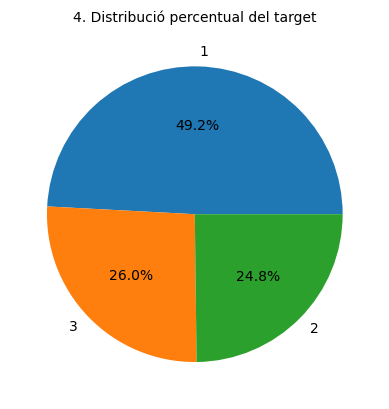

In [35]:
# Pie plot with % of each class/result of the target
figsize=(6, 3)
plt.pie(df_pfinal["1-X-2"].value_counts(), labels=df_pfinal["1-X-2"].value_counts().index, autopct="%1.1f%%")
plt.title("4. Distribució percentual del target", fontsize = 10)

plt.show()

In [36]:
# Import alghoritm to balance the samples. 
from imblearn.over_sampling import RandomOverSampler

# balance the dataset
df_pfinal_resampled = RandomOverSampler()
X_resampled, yc_resampled = df_pfinal_resampled.fit_resample(X_train, yc_train)

Text(0, 0.5, 'Frequència')

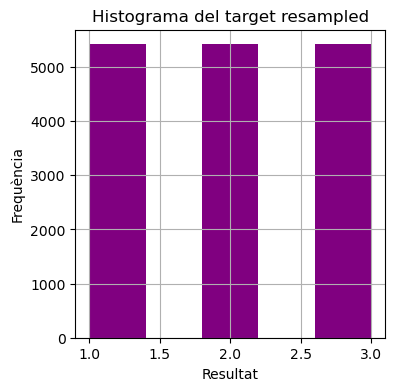

In [37]:
# plot the result to confirm that balanced has been done correctly
plt.figure(figsize = (4, 4))
yc_resampled.hist(bins=5, color = 'purple')
plt.title('Histograma del target resampled')
plt.xlabel("Resultat")
plt.ylabel("Frequència")

In [38]:
from sklearn.model_selection import cross_val_score
# Declare model again
lr_pipeline = Pipeline([('prep', preprocessor), ('lr', LogisticRegression(C=0.15, penalty='l1', solver='liblinear'))])
lr_pipeline.fit(X_resampled, yc_resampled)
yc_bal = lr_pipeline.predict(X_test)

print(f"El mejor resultado para F1 es {f1_score(yc_test, yc_bal, average='micro'):.3f}")
print(f"El mejor resultado para accuracy es {accuracy_score(yc_test, yc_bal):.3f}")


El mejor resultado para F1 es 0.466
El mejor resultado para accuracy es 0.466


No ha millorat el resultat que teniem per tant ens quedem amb l'original amb millors parametres.

## PREDICCIONS

In [39]:
# Import two dataset create
prediccions34 = pd.read_csv("jornada34.csv", sep = ",", encoding="utf-8-sig")

# Unify name of columns
prediccions34.columns = ["Temp", "Jor", "Data", "Loc", "Vis", "LG", "VG", "1-X-2", "LP", "VP", "L10gf_cL", "V10gf_cV", "L10gc_cL", "V10gc_cV", "L10r", "V10r", "LV_10cL", "LE_10cL", "LD_10cL", "VV_10cV", "VE_10cV", "VD_10cV", "Per", "L_Han", "V_Han"]

# Show principal dataset
prediccions34

,Temp,Jor,Data,Loc,Vis,LG,VG,1-X-2,LP,VP,L10gf_cL,V10gf_cV,L10gc_cL,V10gc_cV,L10r,V10r,LV_10cL,LE_10cL,LD_10cL,VV_10cV,VE_10cV,VD_10cV,Per,L_Han,V_Han
0,2022-23,34,2023-05-14,Betis,Rayo Vallecano,-1,-1,X,1,1,1.1,0.8,1.1,1.4,1.3,1.2,3.0,4.0,3.0,3.0,3.0,4.0,4,3,4
1,2022-23,34,2023-05-14,Celta de Vigo,Valencia,-1,-1,X,1,1,1.3,0.5,0.8,1.5,1.5,0.3,4.0,3.0,3.0,1.0,0.0,9.0,4,3,3
2,2022-23,34,2023-05-14,Villarreal,Athletic Club,-1,-1,X,1,1,1.6,1.1,1.0,1.0,1.9,1.5,6.0,1.0,3.0,4.0,3.0,3.0,4,3,3
3,2022-23,34,2023-05-14,Elche,Atlético de Madrid,-1,-1,X,1,1,1.2,1.4,1.6,1.0,0.8,1.7,2.0,2.0,6.0,5.0,2.0,3.0,4,4,1
4,2022-23,34,2023-05-14,Espanyol,Barcelona,-1,-1,X,1,1,1.1,1.3,1.3,0.5,1.2,2.2,3.0,3.0,4.0,7.0,1.0,2.0,4,3,1
5,2022-23,34,2023-05-14,Real Madrid,Getafe,-1,-1,X,1,1,2.6,0.6,0.8,1.5,2.3,0.3,7.0,2.0,1.0,0.0,3.0,7.0,4,1,3
6,2022-23,34,2023-05-14,Mallorca,Cádiz,-1,-1,X,1,1,1.3,0.7,0.6,1.5,2.1,0.9,6.0,3.0,1.0,2.0,3.0,5.0,4,3,4
7,2022-23,34,2023-05-14,Valladolid,Sevilla,-1,-1,X,1,1,1.2,1.0,1.6,1.6,1.4,1.2,4.0,2.0,4.0,3.0,3.0,4.0,4,4,2
8,2022-23,34,2023-05-14,Osasuna,Almería,-1,-1,X,1,1,0.9,1.3,1.3,2.4,1.3,0.6,4.0,1.0,5.0,1.0,3.0,6.0,4,3,4
9,2022-23,34,2023-05-14,Real Sociedad,Girona,-1,-1,X,1,1,1.5,1.3,0.5,1.4,2.1,1.2,6.0,3.0,1.0,3.0,3.0,4.0,4,3,4


In [40]:
# Define features of dataset for prediction
predX = prediccions34[['Per', 'Loc', 'Vis', 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 'V_Han', 'V10r', 
               'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV']]

# Recall and fit the model with best options
# Declare model again
lr_pipeline = Pipeline([('prep',preprocessor), ('lr', LogisticRegression(C = 0.15, penalty = 'l1', solver = 'liblinear'))])
lr_pipeline.fit(X, yc)

# Predict local goals
yc_pred_34 = lr_pipeline.predict(predX)


print("\033[1mResultat quiniela\033[0m")
print("Prediccions reals:", yc_pred_34)

Resultat quiniela
Prediccions reals: [1 1 1 2 2 1 1 2 1 1]


In [41]:
# Create a df with the predictions
pred_jornada34 = prediccions34[["Temp", "Jor", "Data", "Loc", "Vis", "1-X-2"]]
pred_jornada34 = pred_jornada34.assign(Predq=yc_pred_34)
pred_jornada34

,Temp,Jor,Data,Loc,Vis,1-X-2,Predq
0,2022-23,34,2023-05-14,Betis,Rayo Vallecano,X,1
1,2022-23,34,2023-05-14,Celta de Vigo,Valencia,X,1
2,2022-23,34,2023-05-14,Villarreal,Athletic Club,X,1
3,2022-23,34,2023-05-14,Elche,Atlético de Madrid,X,2
4,2022-23,34,2023-05-14,Espanyol,Barcelona,X,2
5,2022-23,34,2023-05-14,Real Madrid,Getafe,X,1
6,2022-23,34,2023-05-14,Mallorca,Cádiz,X,1
7,2022-23,34,2023-05-14,Valladolid,Sevilla,X,2
8,2022-23,34,2023-05-14,Osasuna,Almería,X,1
9,2022-23,34,2023-05-14,Real Sociedad,Girona,X,1
